# Introduction: Graphing NYC Bike Paths

The objective of this notebook is to produce an animated graph showing the growth of NYC bike paths over time. We'll start with open data from NYC and convert it into a format that we can plot with Plotly.

In [1]:
import geopandas as gpd

gdf = gpd.read_file('20180906_current_bike_network/20180906_current_bike_network.shp')

Our data is in a geodataframe which is like a pandas dataframe but includes specific geographic capabilities. The geographic information is stored in `geometry`.

In [2]:
gdf.head()

,OBJECTID,segmentmil,SegmentID,LaneMiles,BikeID,Shape_Leng,OBJECTID_1,street,boro,facilitycl,fromstreet,tostreet,lasteditby,onoffst,allclasses,instdate,moddate,comments,bikedir,lanecount,ft_facilit,tf_facilit,geometry
0,1,0.049849,33547,0.049849,65.0,263.204281,64,9 AV,1.0,I,W 16 ST,W 31 ST,DCP,ON,I,2008-09-25,2008-09-25,None,L,1.0,None,Protected Path,LINESTRING (984139.5802614242 211708.657997250...
1,2,0.051508,22630,0.051508,916.0,271.962807,908,3 AV,3.0,II,DEAN ST,15 ST,DCP,ON,II,1980-07-01,1980-07-01,None,R,1.0,Standard,None,LINESTRING (987723.1852989197 185455.075990095...
2,3,0.069931,299123,0.069931,972.0,369.238067,964,ADAMS ST,3.0,III,TILLARY ST,SANDS ST,BDH,ON,III,2006-06-01,2017-07-01,downgrade to shared,L,1.0,None,Sharrows,LINESTRING (987438.3128371686 193342.969663083...
3,4,0.192899,34170,0.192899,558.0,1018.506071,550,W 39 ST,1.0,III,5 AV,8 AV,DCP,ON,III,2012-09-12,2012-09-12,None,R,1.0,Sharrows,None,LINESTRING (989161.0269114226 213097.043999999...
4,5,0.051184,43043,0.051184,1476.0,270.250237,1468,THROOP AV,3.0,II,FLUSHING AV,FULTON ST,DCP,ON,II,2003-06-01,2003-06-01,None,L,1.0,None,Standard,LINESTRING (1000475.800541669 189124.356709256...


We'll fill in the missing values in this column so we can color the map by the type of path.

In [3]:
gdf['tf_facilit'] = gdf['tf_facilit'].fillna('unknown')
gdf['ft_facilit'] = gdf['ft_facilit'].fillna('unknown')

Objective:
* Routes over time.
* When were the most routes made
* Future projections for routes
* Interactive plot of routes

# First Plot

Geopandas makes it very easy to quickly make a geographic plot. Here is our first attempt.

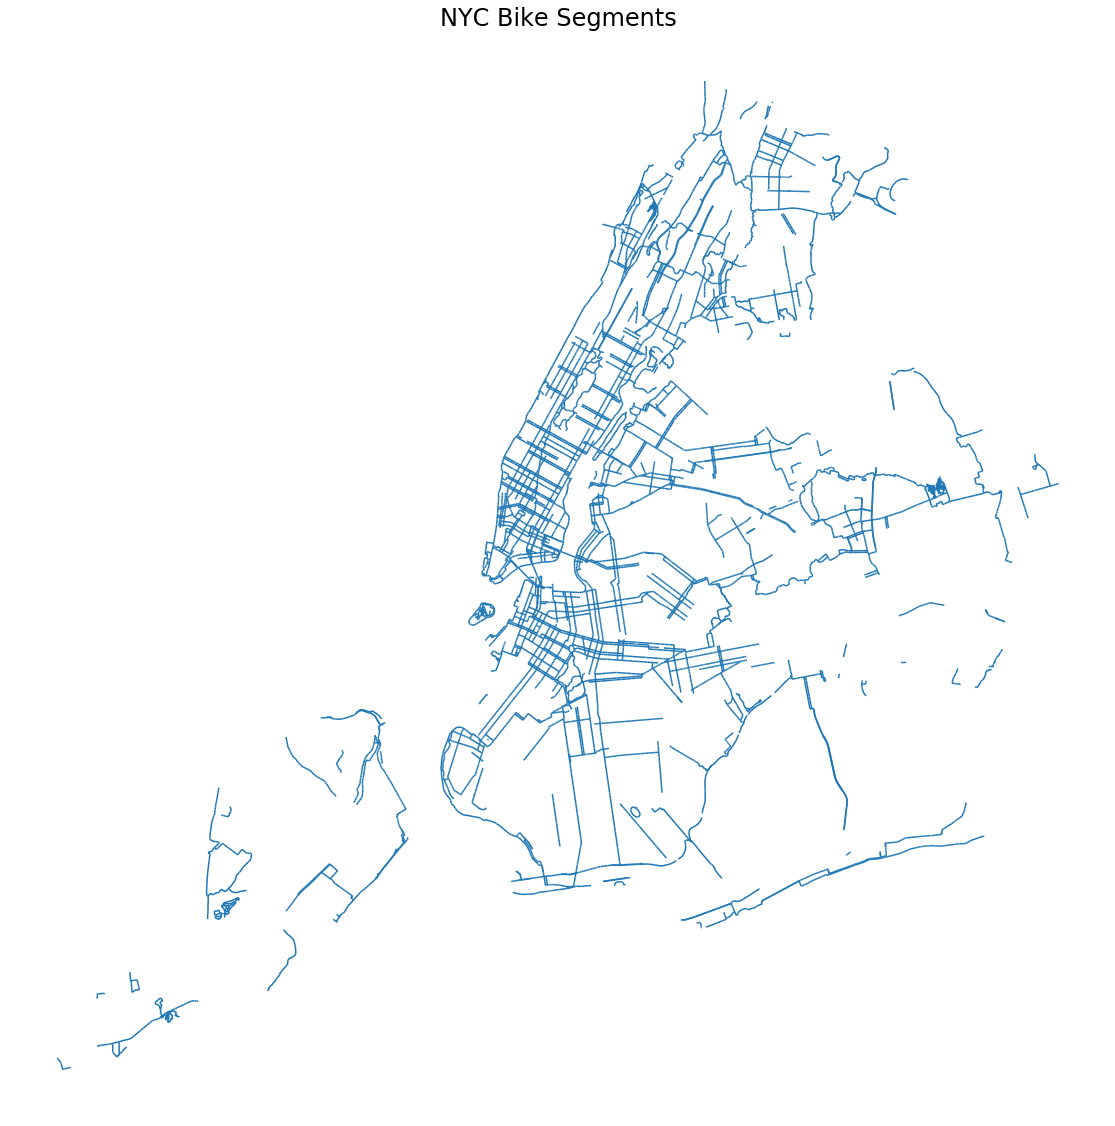

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(20, 20))
ax = plt.gca()
_ = gdf.plot(ax=ax)
_ = ax.set_title('NYC Bike Segments', size=24)
_ = ax.axis('off')

We can color by any of the variables, for example, the facility type.

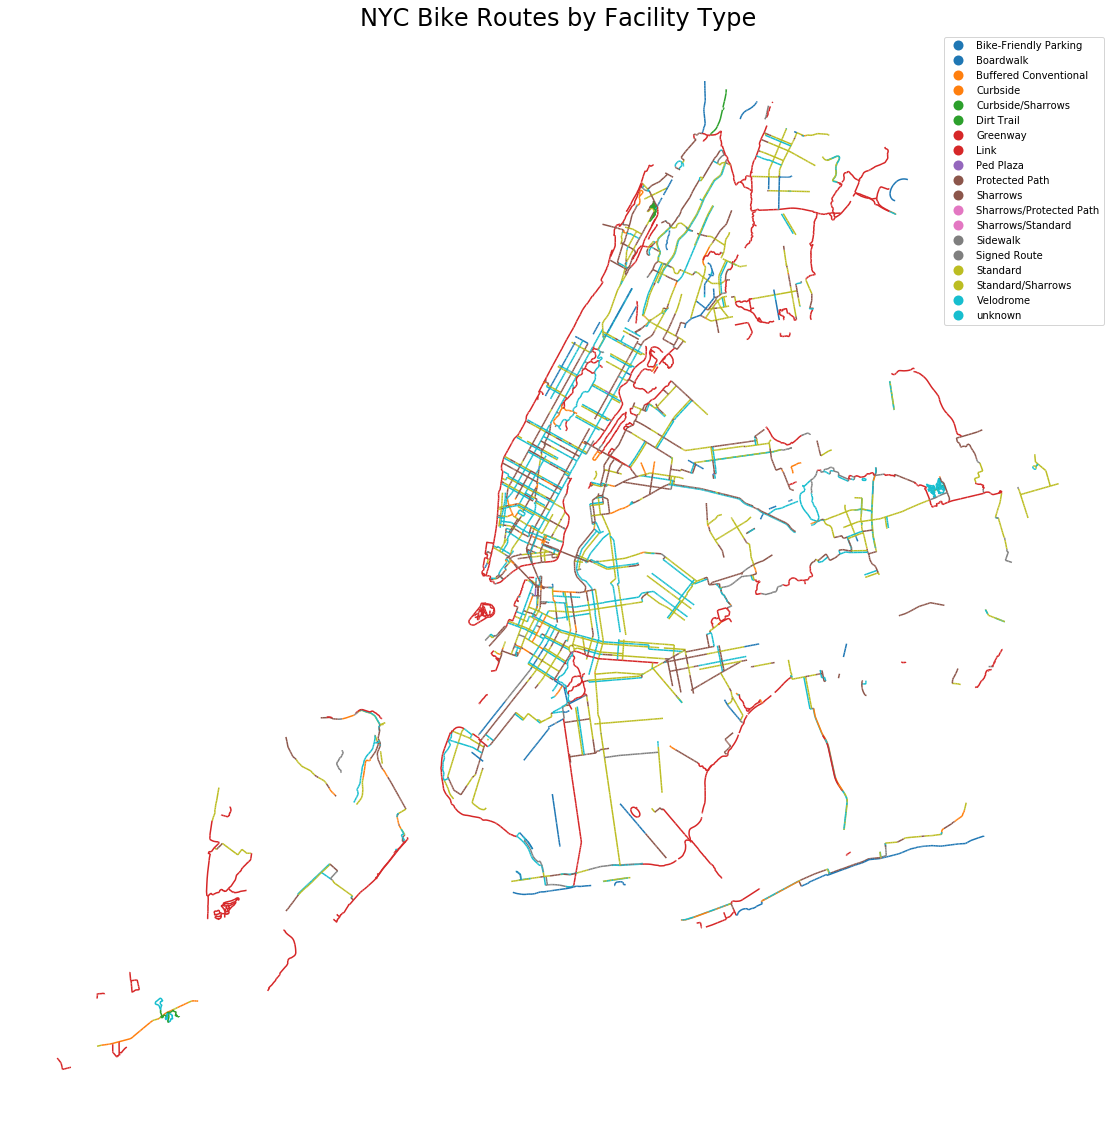

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(20, 20))
ax = plt.gca()
_ = gdf.plot(column='tf_facilit', ax=ax, legend=True)
_ = ax.set_title('NYC Bike Routes by Facility Type', size=24)
_ = ax.axis('off')

# Adding a Basemap

The next step is to add a basemap. This is a basic map underlying our map showing geography, infrastructure, political boundaries, terrain, etc. The information we place on top is a layer.

## Change the Coordinate Reference System

The coordinate reference system (crs) refers to the encoding of the geographic information (in `geometry`). There are two types of crs:

* projected: used for projecting latitude and longitude coordinates onto a 2D surface
* unprojected: latitude and longitude coordinates

The geodataframe is currently in a projected crs. To use `contextily`, we need to use the epsg: 3857 crs which is also projected. To get the latitude and longitude, we can convert to epsg:4327.

In [6]:
# Make sure we are using the correct coordinate reference system
gdf = gdf.to_crs(epsg=3857)
gdf.crs

{'init': 'epsg:3857', 'no_defs': True}

We can see the difference in coordinate systems by looking at the coordinates.

In [7]:
list(gdf['geometry'].iloc[0].coords)

[(-8237686.68052387, 4975208.3720366275),
 (-8237635.302419021, 4975301.15346907)]

These are x-y coordinates. We can now convert to latitude and longitude and view the coordinates.

In [8]:
unprojected_gdf = gdf.to_crs(epsg=4327)
unprojected_gdf.crs

{'init': 'epsg:4327', 'no_defs': True}

In [9]:
list(unprojected_gdf['geometry'].iloc[0].coords)

[(-74.00039850902397, 40.74776789154447),
 (-73.99993697165543, 40.74839931726863)]

Now our coordinates are in (longitude, latitude) pairs corresponding to a Mercator Project. We'll use these coordinates later for working with plotly. 

Now, we can get back to adding a basemap with contextily.

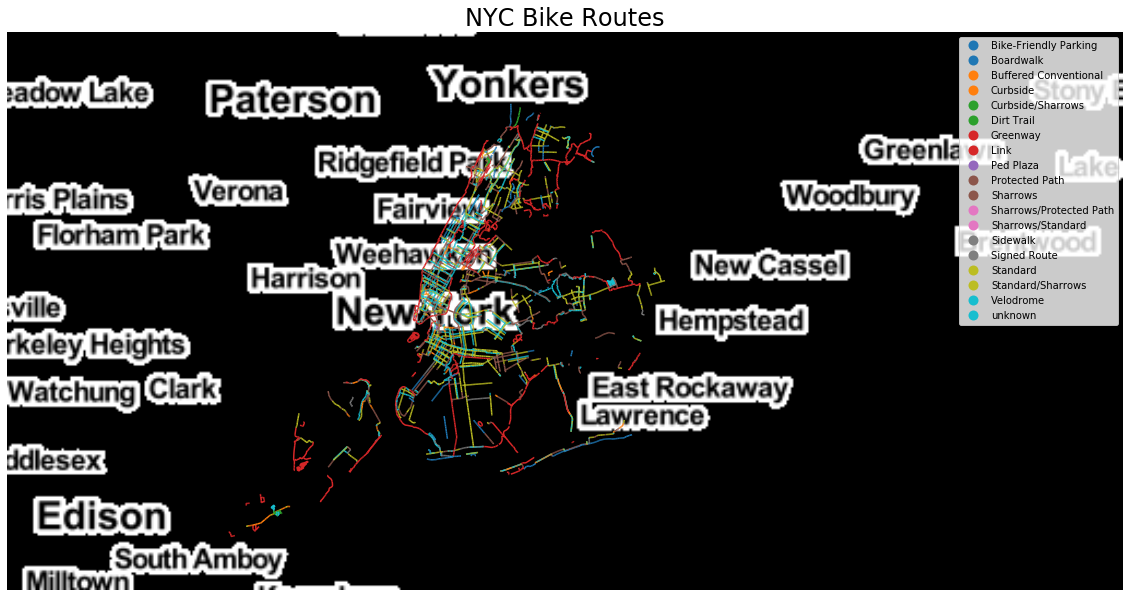

In [11]:
import contextily as ctx

def plot_with_basemap(
    gdf, column, zoom, url=ctx.sources.ST_TONER_HYBRID
):
    """
    Plot a geodataframe with a basemap. The geodata frame must be in epsg:3857 crs.
    """
    gdf = gdf.copy()
    
    
    # Create the figure
    _ = plt.figure(figsize=(20, 20))
    ax = plt.gca()
    _ = gdf.plot(column=column, ax=ax, legend=True)
    _ = ax.set_title("NYC Bike Routes", size=24)
    
    # Get the bounds of the axes
    xmin, xmax, ymin, ymax = ax.axis()
    
    # Retrieve the image from the url
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation="bilinear")
    _ = ax.axis("off")
    plt.show()
    
plot_with_basemap(gdf, column='tf_facilit', zoom=9)

## Interactive Basemap

To get an idea of the different basemaps, we can make our function interactive. This will let us rapidly cycle through different basemaps.

In [13]:
from ipywidgets import interact_manual

@interact_manual
def plot_with_basemap(
    zoom=10,
    style=[
        "ST_TERRAIN",
        "ST_TERRAIN_BACKGROUND",
        "ST_TERRAIN_LABELS",
        "ST_TERRAIN_LINES",
        "ST_TONER",
        "ST_TONER_BACKGROUND",
        "ST_TONER_HYBRID",
        "ST_TONER_LINES",
        "ST_TONER_LITE",
        "ST_WATERCOLOR",
    ],
):
    # Create the figure
    _ = plt.figure(figsize=(20, 20))
    ax = plt.gca()
    _ = gdf.plot(column="tf_facilit", ax=ax, legend=True)
    _ = ax.set_title("NYC Bike Routes", size=24)

    # Get the bounds of the axes
    xmin, xmax, ymin, ymax = ax.axis()

    # Retrieve the image from the url
    basemap, extent = ctx.bounds2img(
        xmin, ymin, xmax, ymax, zoom=zoom, url=getattr(ctx.sources, style)
    )
    ax.imshow(basemap, extent=extent, interpolation="bilinear")
    _ = ax.axis("off")
    plt.show()

interactive(children=(IntSlider(value=10, description='zoom', max=30, min=-10), Dropdown(description='style', …

# Make Routes

The data currently contains `segments` for each bike route. I'm not entirely sure what a segment is supposed to represent, but it makes more sense to me if we group together routes based on `fromstreet` and `tostreet`. We also want to keep track of the direction, given in `bikedir`. 

In [14]:
gdf['route'] = gdf['fromstreet'] + ' to ' + gdf['tostreet'] + ' ' + gdf['bikedir']
gdf['route'].value_counts()

E 161 ST to VAN CORTLANDT AVE E R     142
E 161 ST to VAN CORTLANDT AVE E L     142
BATTERY PARK GREENWAY to W 59 ST 2     86
EMMONS AV to DIVISION AV 2             85
BEACH 126 St to BEACH 39 ST 2          81
SEA BREEZE AV to CHURCH AV 2           64
E 25 ST to JOHN ST 2                   63
MALCOLM X BLVD to HUDSON AV L          63
E 96 ST to E 124 ST R                  59
E 125 ST to E 60 ST 2                  57
                                     ... 
BEDFORD AV to FOSTER AV R               1
HARRISON AV to TOMPKINS AV L            1
HUNTINGTON ST to W 9 ST L               1
PITKIN AV to E NEW YORK AV R            1
3 AV to FT GREENE PL R                  1
W 160 ST to BROADWAY 2                  1
WHIPPLE ST to MANHATTAN AV L            1
LIBERTY ST to MAIDEN LN R               1
AVE V to AVE U 2                        1
PLIMPTON AVE to OGDEN AVE 2             1
Name: route, Length: 2047, dtype: int64

Let's take a look at the longest routes.

In [15]:
gdf.groupby('route')['LaneMiles'].sum().sort_values().tail()

route
SEA BREEZE AV to CHURCH AV 2           9.713069
BATTERY PARK GREENWAY to W 59 ST 2     9.999883
BAY PKWY to SHORE RD 2                10.868406
BRIGHAM ST to KINGS-QN CNTY BNDY 2    11.727482
EMMONS AV to DIVISION AV 2            13.018540
Name: LaneMiles, dtype: float64

## Combine Segments into Routes

To combine the segments into routes, we simply need to join together the individual line segments. The info is the same, it will just be represented as routes instead of segments.

Text(0, 0.5, 'Miles')

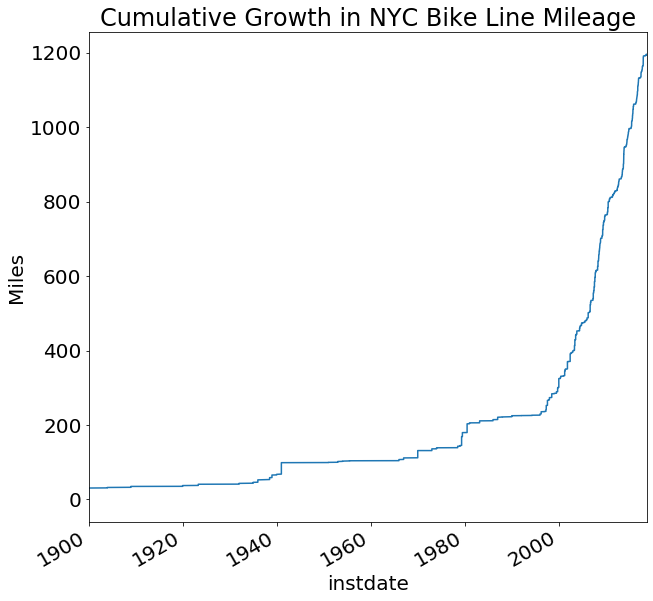

In [35]:

plt.rcParams['font.size'] = 20
ax = df.set_index('instdate')['cumulative_miles'].plot(title='Cumulative Growth in NYC Bike Line Mileage', figsize=(10, 10))
ax.set_ylabel('Miles')

In [27]:
import plotly_express as px

px.line(df, x='instdate', y='cumulative_miles')

ValueError: Invalid property specified for object of type plotly.graph_objs.Scatter: 'hovertemplate'

    Valid properties:
        cliponaxis
            Determines whether or not markers and text nodes are
            clipped about the subplot axes. To show markers and
            text nodes above axis lines and tick labels, make sure
            to set `xaxis.layer` and `yaxis.layer` to *below
            traces*.
        connectgaps
            Determines whether or not gaps (i.e. {nan} or missing
            values) in the provided data arrays are connected.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on plot.ly for  customdata .
        dx
            Sets the x coordinate step. See `x0` for more info.
        dy
            Sets the y coordinate step. See `y0` for more info.
        error_x
            plotly.graph_objs.scatter.ErrorX instance or dict with
            compatible properties
        error_y
            plotly.graph_objs.scatter.ErrorY instance or dict with
            compatible properties
        fill
            Sets the area to fill with a solid color. Defaults to
            "none" unless this trace is stacked, then it gets
            "tonexty" ("tonextx") if `orientation` is "v" ("h") Use
            with `fillcolor` if not "none". "tozerox" and "tozeroy"
            fill to x=0 and y=0 respectively. "tonextx" and
            "tonexty" fill between the endpoints of this trace and
            the endpoints of the trace before it, connecting those
            endpoints with straight lines (to make a stacked area
            graph); if there is no trace before it, they behave
            like "tozerox" and "tozeroy". "toself" connects the
            endpoints of the trace (or each segment of the trace if
            it has gaps) into a closed shape. "tonext" fills the
            space between two traces if one completely encloses the
            other (eg consecutive contour lines), and behaves like
            "toself" if there is no trace before it. "tonext"
            should not be used if one trace does not enclose the
            other. Traces in a `stackgroup` will only fill to (or
            be filled to) other traces in the same group. With
            multiple `stackgroup`s or some traces stacked and some
            not, if fill-linked traces are not already consecutive,
            the later ones will be pushed down in the drawing
            order.
        fillcolor
            Sets the fill color. Defaults to a half-transparent
            variant of the line color, marker color, or marker line
            color, whichever is available.
        groupnorm
            Only relevant when `stackgroup` is used, and only the
            first `groupnorm` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the normalization for the sum of
            this `stackgroup`. With "fraction", the value of each
            trace at each location is divided by the sum of all
            trace values at that location. "percent" is the same
            but multiplied by 100 to show percentages. If there are
            multiple subplots, or multiple `stackgroup`s on one
            subplot, each will be normalized within its own set.
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on plot.ly for  hoverinfo .
        hoverlabel
            plotly.graph_objs.scatter.Hoverlabel instance or dict
            with compatible properties
        hoveron
            Do the hover effects highlight individual points
            (markers or line points) or do they highlight filled
            regions? If the fill is "toself" or "tonext" and there
            are no markers or text, then the default is "fills",
            otherwise it is "points".
        hovertext
            Sets hover text elements associated with each (x,y)
            pair. If a single string, the same string appears over
            all the data points. If an array of string, the items
            are mapped in order to the this trace's (x,y)
            coordinates. To be seen, trace `hoverinfo` must contain
            a "text" flag.
        hovertextsrc
            Sets the source reference on plot.ly for  hovertext .
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on plot.ly for  ids .
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        line
            plotly.graph_objs.scatter.Line instance or dict with
            compatible properties
        marker
            plotly.graph_objs.scatter.Marker instance or dict with
            compatible properties
        mode
            Determines the drawing mode for this scatter trace. If
            the provided `mode` includes "text" then the `text`
            elements appear at the coordinates. Otherwise, the
            `text` elements appear on hover. If there are less than
            20 points and the trace is not stacked then the default
            is "lines+markers". Otherwise, "lines".
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        opacity
            Sets the opacity of the trace.
        orientation
            Only relevant when `stackgroup` is used, and only the
            first `orientation` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Sets the stacking direction. With "v"
            ("h"), the y (x) values of subsequent traces are added.
            Also affects the default value of `fill`.
        r
            r coordinates in scatter traces are deprecated!Please
            switch to the "scatterpolar" trace type.Sets the radial
            coordinatesfor legacy polar chart only.
        rsrc
            Sets the source reference on plot.ly for  r .
        selected
            plotly.graph_objs.scatter.Selected instance or dict
            with compatible properties
        selectedpoints
            Array containing integer indices of selected points.
            Has an effect only for traces that support selections.
            Note that an empty array means an empty selection where
            the `unselected` are turned on for all points, whereas,
            any other non-array values means no selection all where
            the `selected` and `unselected` styles have no effect.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        stackgaps
            Only relevant when `stackgroup` is used, and only the
            first `stackgaps` found in the `stackgroup` will be
            used - including if `visible` is "legendonly" but not
            if it is `false`. Determines how we handle locations at
            which other traces in this group have data but this one
            does not. With *infer zero* we insert a zero at these
            locations. With "interpolate" we linearly interpolate
            between existing values, and extrapolate a constant
            beyond the existing values.
        stackgroup
            Set several scatter traces (on the same subplot) to the
            same stackgroup in order to add their y values (or
            their x values if `orientation` is "h"). If blank or
            omitted this trace will not be stacked. Stacking also
            turns `fill` on by default, using "tonexty" ("tonextx")
            if `orientation` is "h" ("v") and sets the default
            `mode` to "lines" irrespective of point count. You can
            only stack on a numeric (linear or log) axis. Traces in
            a `stackgroup` will only fill to (or be filled to)
            other traces in the same group. With multiple
            `stackgroup`s or some traces stacked and some not, if
            fill-linked traces are not already consecutive, the
            later ones will be pushed down in the drawing order.
        stream
            plotly.graph_objs.scatter.Stream instance or dict with
            compatible properties
        t
            t coordinates in scatter traces are deprecated!Please
            switch to the "scatterpolar" trace type.Sets the
            angular coordinatesfor legacy polar chart only.
        text
            Sets text elements associated with each (x,y) pair. If
            a single string, the same string appears over all the
            data points. If an array of string, the items are
            mapped in order to the this trace's (x,y) coordinates.
            If trace `hoverinfo` contains a "text" flag and
            "hovertext" is not set, these elements will be seen in
            the hover labels.
        textfont
            Sets the text font.
        textposition
            Sets the positions of the `text` elements with respects
            to the (x,y) coordinates.
        textpositionsrc
            Sets the source reference on plot.ly for  textposition
            .
        textsrc
            Sets the source reference on plot.ly for  text .
        tsrc
            Sets the source reference on plot.ly for  t .
        uid

        unselected
            plotly.graph_objs.scatter.Unselected instance or dict
            with compatible properties
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the x coordinates.
        x0
            Alternate to `x`. Builds a linear space of x
            coordinates. Use with `dx` where `x0` is the starting
            coordinate and `dx` the step.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xcalendar
            Sets the calendar system to use with `x` date data.
        xsrc
            Sets the source reference on plot.ly for  x .
        y
            Sets the y coordinates.
        y0
            Alternate to `y`. Builds a linear space of y
            coordinates. Use with `dy` where `y0` is the starting
            coordinate and `dy` the step.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ycalendar
            Sets the calendar system to use with `y` date data.
        ysrc
            Sets the source reference on plot.ly for  y .
        

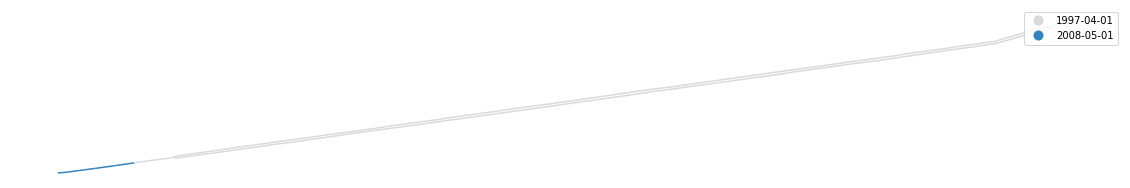

In [22]:
_ = plt.figure(figsize=(20, 20))
_ = ax = plt.gca()

_ = gdf[gdf['route'] == '59 ST to 113 ST'].plot(column='moddate', ax=ax, legend=True, cmap=plt.cm.tab20c_r)
_ = ax.axis('off')

In [5]:
gdf[gdf['route'] == 'PARK DR E to 164 ST']

,OBJECTID,segmentmil,SegmentID,LaneMiles,BikeID,Shape_Leng,OBJECTID_1,street,boro,facilitycl,fromstreet,tostreet,lasteditby,onoffst,allclasses,instdate,moddate,comments,bikedir,lanecount,ft_facilit,tf_facilit,geometry,route
5409,5410,0.072009,89801,0.144018,1874.0,380.208730,1866,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,1979-07-01,1979-07-01,None,2,2.0,Standard,Standard,LINESTRING (1030895.415555343 204566.093214169...,PARK DR E to 164 ST
5410,5411,0.054377,89861,0.108753,1874.0,287.107935,1866,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,1979-07-01,1979-07-01,None,2,2.0,Standard,Standard,LINESTRING (1031271.430223256 204540.115903928...,PARK DR E to 164 ST
5411,5412,0.049761,89862,0.099523,1874.0,262.740106,1866,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,1979-07-01,1979-07-01,None,2,2.0,Standard,Standard,LINESTRING (1031533.985472426 204656.286931425...,PARK DR E to 164 ST
5412,5413,0.055483,89865,0.110966,1874.0,292.949604,1866,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,1979-07-01,1979-07-01,None,2,2.0,Standard,Standard,LINESTRING (1031776.711364925 204756.867767006...,PARK DR E to 164 ST
5415,5416,0.114334,90029,0.228669,1874.0,603.685317,1866,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,1979-07-01,1979-07-01,None,2,2.0,Standard,Standard,LINESTRING (1032047.563841596 204868.484997838...,PARK DR E to 164 ST
5416,5417,0.034622,90048,0.069244,1874.0,182.804828,1866,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,1979-07-01,1979-07-01,None,2,2.0,Standard,Standard,LINESTRING (1032612.500047669 205081.283128678...,PARK DR E to 164 ST
5421,5422,0.126913,90187,0.253825,1877.0,670.098750,1869,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,2007-10-01,2007-10-01,None,2,2.0,Standard,Standard,LINESTRING (1033721.999141008 205505.724537000...,PARK DR E to 164 ST
5423,5424,0.096742,90331,0.193485,1877.0,510.799201,1869,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,2007-10-01,2007-10-01,None,2,2.0,Standard,Standard,LINESTRING (1034345.160952419 205752.101668924...,PARK DR E to 164 ST
6599,6600,0.055059,131463,0.110119,1874.0,290.713860,1866,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,1979-07-01,1979-07-01,None,2,2.0,Standard,Standard,LINESTRING (1032785.436053514 205140.534650594...,PARK DR E to 164 ST
6657,6658,0.050994,133506,0.050994,1876.0,269.247101,1868,JEWEL AV,4.0,II,PARK DR E,164 ST,DCP,ON,II,2007-10-01,2007-10-01,None,L,1.0,unknown,Standard,LINESTRING (1036405.65223825 206132.3568139225...,PARK DR E to 164 ST


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(20, 20))
ax = plt.gca()
_ = gdf[gdf[''.plot(column='tf_facilit', ax=ax, legend=True)
_ = ax.set_title('NYC Bike Routes by Facility Type', size=24)
_ = ax.axis('off')

# Routes Colored by Facility Type

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.figure(figsize=(20, 20))
ax = plt.gca()
_ = gdf.plot(column='tf_facilit', ax=ax, legend=True)
_ = ax.set_title('NYC Bike Routes by Facility Type', size=24)
_ = ax.axis('off')

## Routes Colored By Year

In [ ]:
gdf['year'] = pd.to_datetime(gdf['date_instd']).dt.year

_ = plt.figure(figsize=(20, 20))
ax = plt.gca()
_ = gdf.plot(column='year', ax=ax, legend=True, cmap=plt.cm.cividis_r)
_ = ax.set_title('NYC Bike Routes by Year', size=24)
_ = ax.axis('off')

# Adding A Basemap 

We can use the `contextily` library to add a basemap. One thing we have to do first is convert the coordinate reference system of the dataframe from projected (epsg: 4326) to unprojected (epsh: 3857). This is done with a utility function on the geodataframe.

In [ ]:
web_gdf = gdf.to_crs(epsg=3857)
web_gdf.geometry[:2]

In [ ]:
web_gdf.crs

In [ ]:
gdf.crs

In [ ]:
plot_with_basemap(gdf, column='tf_facilit', zoom=12)

## Interactive Version

We can make the choosing the basemap and zoom level more interactive with IPython Widgets.

# Finding Length of Bike Routes

In [ ]:
example = gdf['geometry'].iloc[0]
list(example.coords)

Distance is 0.08 KM from https://www.geodatasource.com/distance-calculator

In [ ]:
example.length

In [ ]:
web_gdf['geometry'].iloc[0].length

In [ ]:
gdf[(gdf['fromstreet'] == 'W 16 ST') & (gdf['tostreet'] == 'W 31 ST')]

In [ ]:
from shapely.geometry import LineString
from math import radians, cos, sin, asin, sqrt

# Calculates distance between 2 GPS coordinates
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 3956 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

distances = []
for line in gdf['geometry']:
    try:
        numCoords = len(line.coords) - 1
        distance = 0
        for i in range(0, numCoords):
            point1 = line.coords[i]
            point2 = line.coords[i + 1]
            distance += d(point1, point2).meters

        distances.append(distance)
    except: 
        continue
distances[:10]

In [ ]:
new = gdf.to_crs(epsg=32633)
new['geometry'].iloc[0].length

In [ ]:
gdf.iloc[0]

In [ ]:
from geopy import distance
from shapely.wkt import loads

line_wkt="LINESTRING(3.0 4.0, 3.1 4.1)"

# a number of other elipsoids are supported
distance.VincentyDistance.ELLIPSOID = 'WGS-84'
d = distance.distance

line = loads(line_wkt)

# convert the coordinates to xy array elements, compute the distance
dist = d(line.xy[0], line.xy[1])

print(dist.meters)

In [ ]:
d(example.coords[0], example.coords[1]).meters

In [ ]:
d(example.xy[0], example.xy[1]).meters

# Bringing in Plotly

Next, we will try our hand at using plotly, specifically plotly_express, for plotting an interactive version of this map. This will require a little work.

In [ ]:
import shapely.geometry as geometry

In [ ]:
gdf['geometry'].head(3)

In [ ]:
routes = []

point_lats = []
point_lons = []

types = []
lens = []

# Iterate through each row (a bike route)
for segment in gdf.itertuples():
    
    types.append(type(segment.geometry))
    
    # We will skip multi-line strings for now
    if isinstance(segment.geometry, geometry.multilinestring.MultiLineString):
        segment.geometry
        continue
    
    else:
        # Extract the points forming the line
        points = segment.geometry.xy
        # Record how many points are in the line
        lens.append(len(points[0]))
            
        # Iterate through the longitudes and latitudes making up the line
        for x, y in zip(points[0], points[1]):
            routes.append(segment.segment_id)
            point_lons.append(x)
            point_lats.append(y)
            
    
print(f'There are a total of {len(gdf)} routes.')
print(f'These routes are made up of a total of {len(routes)} points.')

In [ ]:
from collections import Counter

Counter(types)

In [ ]:
point_counts = pd.DataFrame.from_records(dict(Counter(lens)), index=[0]).T.reset_index().rename(columns={0: 'count', 'index': 'n_points'}).sort_values(by='n_points')
point_counts.head()

## Create DataFrame of Bike Routes

The next step is to make a dataframe which the columns contain the route id, the lat, and the lon making up the points in each route.

In [ ]:
df = pd.DataFrame(data=dict(segment_id=routes, lat=point_lats, lon=point_lons))
df.head()

We can join this back to the main dataframe to get metadata about the bike routes.

In [ ]:
df = df.merge(gdf, on='segment_id', how='left')[['segment_id', 'lat', 'lon', 'boro', 'ft_facilit', 'date_instd', 'street']]
df['date_instd'] = pd.to_datetime(df['date_instd'])
df = df.dropna()
df.info()

## Use Plotly Express

We'll import plotly express and authenticate with MapBox to use the geographic plotting capabilities.

In [ ]:
import plotly_express as px
px.set_mapbox_access_token(open('/Users/williamkoehrsen/mapbox_secret.txt').read())

In [ ]:
help(px.line_mapbox)

In [ ]:
fig = px.line_mapbox(
    df.iloc[:10000],
    lat="lat",
    lon="lon",
    color="ft_facilit",
    line_group="segment_id",
    title="NYC Bike Routes",
)

In [ ]:
from plotly.offline import plot
plot(fig)